In [104]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

from statsmodels.tsa.stattools import adfuller, coint
from scipy.optimize import curve_fit
from scipy.stats import linregress, jarque_bera
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve

from typing import Union

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Functions import getTEvents, get_dollar_bars, get_daily_vol, add_vertical_barrier, \
                      get_events_tripple_barrier, get_bins, num_conc_events, sample_weights, \
                      sample_return_weights, get_ind_matrix, get_avg_uniqueness

## Auxilary Functions

In [105]:
def get_weights(d: float, size: int) -> np.ndarray:
    '''
    Computing the weights for differentiating the series
    
        Parameters:
            d (float): differentiating factor
            size (int): length of weights array
            
        Returns:
            w (np.ndarray): array contatining weights
    '''
    w = [1.0]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def plot_weights(dRange: list, nPlots: int, size: int) -> None:
    '''
    Generating plots for weights arrays for different differentiating factors
    
        Parameters:
            dRange (list): list with 2 floats - bounds of the interval
            nPlots (int): number of plots
            size(int): length of each weights array
            
        Returns:
            weights (np.ndarray): array contatining weights
    '''
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = get_weights(d, size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    fig, ax = plt.subplots(figsize=(11, 7))
    ax.plot(w)
    ax.set_xlabel('$k$')
    ax.set_ylabel('$w_k$')
    ax.legend(np.round(np.linspace(dRange[0], dRange[1], nPlots), 2), loc='lower right')
    plt.show()

Example:

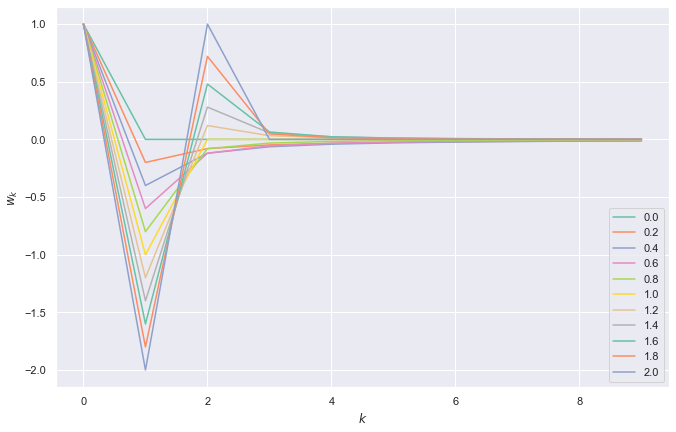

In [106]:
plot_weights(dRange=[0, 2], nPlots=11, size=10)

In [107]:
def frac_diff(series: pd.DataFrame, d: float, thres: float = 0.01) -> pd.DataFrame:
    '''
    Fractional differentiation with increasing width window
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    
        Parameters:
            series (pd.DataFrame): dataframe with time series
            d (float): differentiating factor
            thres (float): threshold for skipping some of the first observations
        
        Returns:
            df (pd.DataFrame): dataframe with differentiated series
    '''
    w = get_weights(d, series.shape[0])
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), \
                       pd.Series(index=np.arange(series.shape[0]), dtype=object)
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue    # exclude NAs
            df_[loc] = np.dot(w[-(iloc + 1):, :].T, seriesF.loc[:loc])[0, 0]
        df[name] = df_.dropna().copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [108]:
def get_weights_ffd(d: float, thres: float) -> np.ndarray:
    '''
    Computing the weights for differentiating the series with fixed window size
    
        Parameters:
            d (float): differentiating factor
            thres (float): threshold for cutting off weights
            
        Returns:
            w (np.ndarray): array contatining weights
    '''
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

In [109]:
def frac_diff_ffd(series: pd.DataFrame, d: float, thres: float = 1e-5) -> pd.DataFrame:
    '''
    Fractional differentiation with constant width window
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    
        Parameters:
            series (pd.DataFrame): dataframe with time series
            d (float): differentiating factor
            thres (float): threshold for cutting off weights
        
        Returns:
            df (pd.DataFrame): dataframe with differentiated series
    '''
    w = get_weights_ffd(d, thres)
    width = len(w) - 1
    
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), \
                       pd.Series(index=np.arange(series.shape[0]), dtype=object)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):
                continue    # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.dropna().copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [110]:
def plot_min_ffd(process: Union[np.ndarray, pd.Series, pd.DataFrame],
                 apply_constant_width: bool = True, thres: float = 0.01) -> None:
    '''
    Finding the minimum differentiating factor that passes the ADF test
    
        Parameters:
            process (np.ndarray): array with random process values
            apply_constant_width (bool): flag that shows whether to use constant width window (if True)
                                         or increasing width window (if False)
            thres (float): threshold for cutting off weights
    '''
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf'], dtype=object)
    printed = False
    
    for d in np.linspace(0, 2, 21):
        if apply_constant_width:
            process_diff = frac_diff_ffd(pd.DataFrame(process), d, thres)
        else:
            process_diff = frac_diff(pd.DataFrame(process), d, thres)    
        test_results = adfuller(process_diff, maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(test_results[:4]) + [test_results[4]['5%']]
        if test_results[1] <= 0.05 and not printed:
            print(f'Minimum d required: {d}')
            printed = True
    
    fig, ax = plt.subplots(figsize=(11, 7))
    ax.plot(out['adfStat'])
    ax.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    ax.set_title('Searching for minimum $d$')
    ax.set_xlabel('$d$')
    ax.set_ylabel('ADF statistics')
    plt.show()

In [111]:
def print_adf_results(process: np.ndarray) -> None:
    '''
    Printing the results of the Augmented Dickey–Fuller test
    '''
    adf, p_value, _, _, _ = adfuller(process, maxlag=1, regression='c', autolag=None)
    print(f'ADF statistics: {adf}')
    print(f'p-value: {p_value}')

## Exercises

### 1. IID Gaussian Random Process

Here I simply use the standard normal distribution:

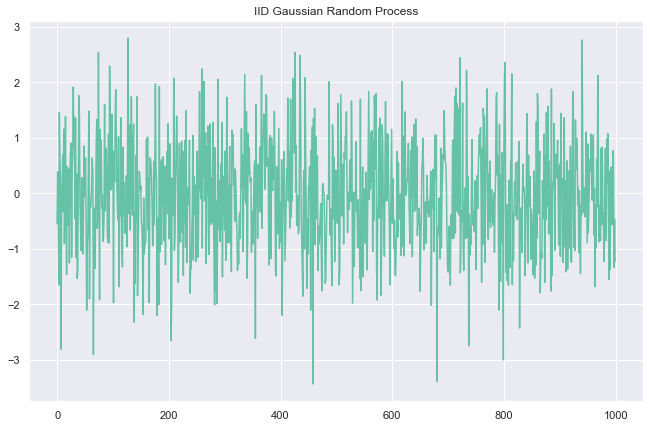

In [112]:
process = np.random.normal(size=1000)
fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(process)
ax.set_title('IID Gaussian Random Process')
plt.show()

In [113]:
print_adf_results(process)

ADF statistics: -20.938508210080354
p-value: 0.0


Naturally, IID Gaussian process is stationary.

Now let's look at the cumulative sum of this process:

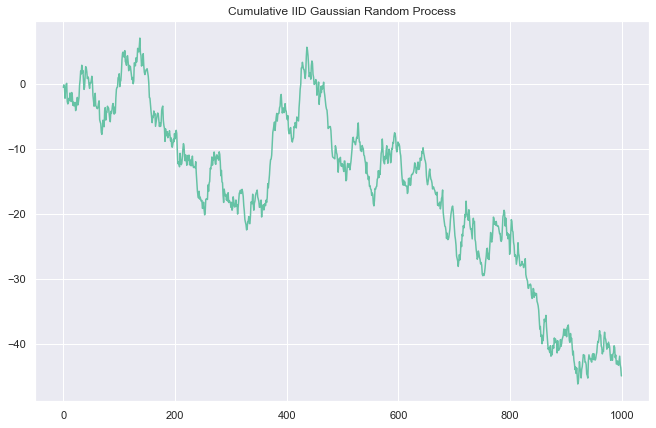

In [114]:
cumulative_process = np.cumsum(process)
fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(cumulative_process)
ax.set_title('Cumulative IID Gaussian Random Process')
plt.show()

In [115]:
print_adf_results(cumulative_process)

ADF statistics: -0.5204622244065241
p-value: 0.8879611983440101


The cumulative Gaussian IID is not stationary. Its order of integration is obviously 1, as diff of the cumulative sum is the original process which is stationary. We can also check what happens if we overdifferentiate this process twice:

In [116]:
diff_process = np.diff(cumulative_process, n=2)
print_adf_results(diff_process)

ADF statistics: -35.981272756264005
p-value: 0.0


### 2. Stationary Series with Memory (Sinusoidal Function)

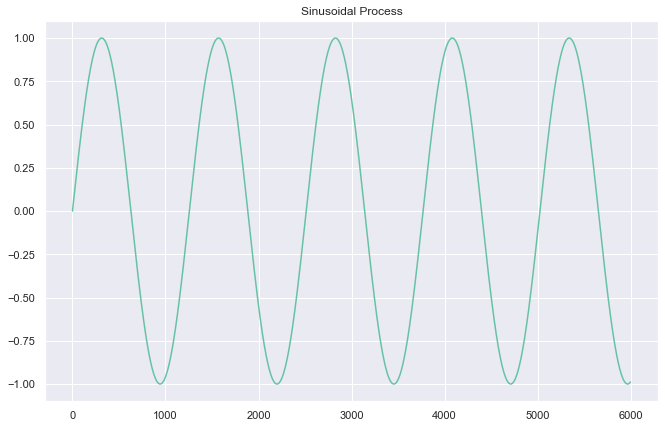

In [117]:
sin_process = np.sin(np.linspace(0, 30, 6000))
fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(sin_process)
ax.set_title('Sinusoidal Process')
plt.show()

In [118]:
print_adf_results(sin_process)

ADF statistics: -783967295192.4526
p-value: 0.0


Now we alter the series - we shift each observation by the same value and then calculate the cumulative sum:

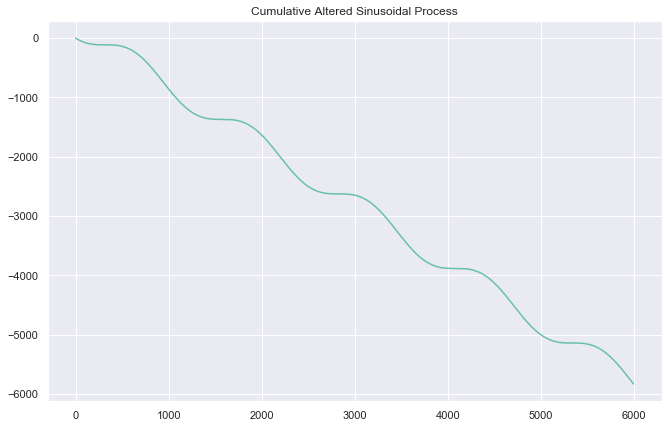

In [119]:
altered_process = np.cumsum(sin_process - 1)
fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(altered_process)
ax.set_title('Cumulative Altered Sinusoidal Process')
plt.show()

In [120]:
print_adf_results(altered_process)

ADF statistics: 0.05844559905176137
p-value: 0.9631067557668846


Expanding window fractional differentiation:

Minimum d required: 0.1


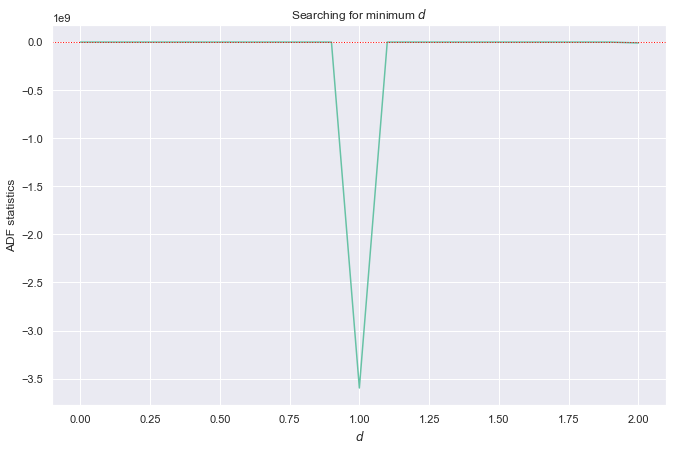

In [121]:
plot_min_ffd(process=altered_process, apply_constant_width=False, thres=0.01)

Constant window fractional differentiation:

Minimum d required: 0.1


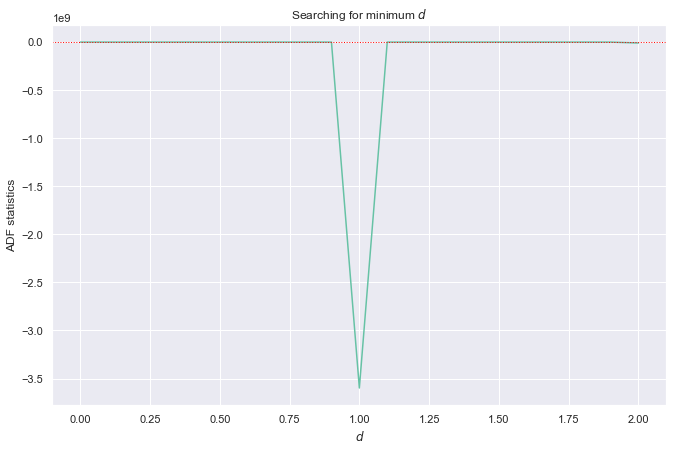

In [122]:
plot_min_ffd(process=altered_process, apply_constant_width=True, thres=1e-5)

### 3. Sine Function Fitting

Here we fit the cumulative shifted sine process (`altered_process` series) to a sine function. Probably the easiest way to do it is by using the `curve_fit` method from `scipy.optimize`.

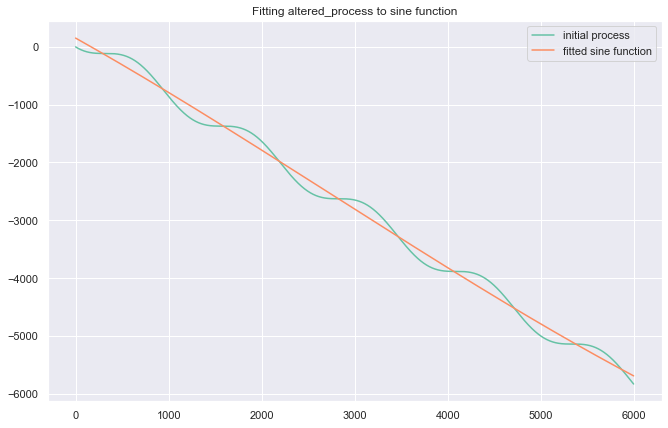

In [123]:
# setting the initial values for parameters
init_freq = 0.1
init_amplitude = np.std(altered_process)
init_phase = 0
init_offset = np.mean(altered_process)
p0 = [init_freq, init_amplitude, init_phase, init_offset]

# function we want to fit our process to
def func_to_fit(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# fitting and plotting the result
fit = curve_fit(func_to_fit, np.linspace(0, 30, 6000), altered_process, p0=p0)
sine_func_fit = func_to_fit(np.linspace(0, 30, 6000), *fit[0])

fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(altered_process, label='initial process')
ax.plot(sine_func_fit, label='fitted sine function')
ax.set_title('Fitting altered_process to sine function')
plt.legend()
plt.show()

In [124]:
slope, intercept, rvalue, pvalue, se = linregress(altered_process, sine_func_fit)
print(f'R-squared for sine fitting: {rvalue ** 2}')

R-squared for sine fitting: 0.9935886426595297


Now we apply the same sine fitting to the fractionally differentiated process with `d=1`:

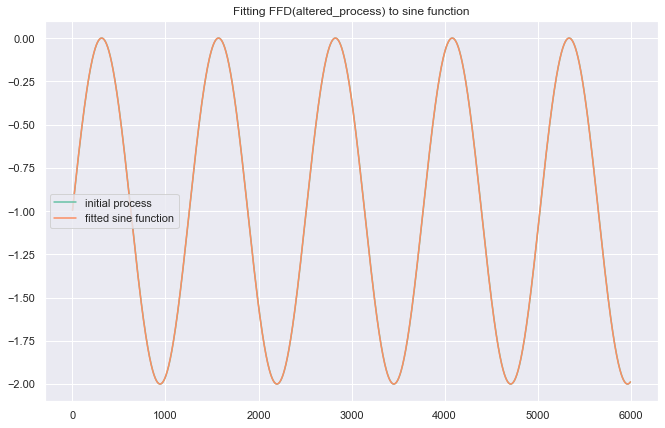

In [125]:
ffd_process = frac_diff_ffd(series=pd.DataFrame(altered_process), d=1.0)

init_freq = 1
init_amplitude = np.std(altered_process)
init_phase = 0
init_offset = np.mean(altered_process)
p0 = [init_freq, init_amplitude, init_phase, init_offset]

fit = curve_fit(func_to_fit, np.linspace(0, 30, 6000)[1:], ffd_process[0], p0=p0)
sine_func_fit = func_to_fit(np.linspace(0, 30, 6000)[1:], *fit[0])

fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(ffd_process, label='initial process')
ax.plot(sine_func_fit, label='fitted sine function')
ax.set_title('Fitting FFD(altered_process) to sine function')
plt.legend()
plt.show()

In [126]:
slope, intercept, rvalue, pvalue, se = linregress(ffd_process[0].values.astype(float), sine_func_fit.astype(float))
print(f'R-squared for sine fitting: {rvalue ** 2}')

R-squared for sine fitting: 1.0


Obviously, when we differentiate the process, we get the initial sine process which can be perfectly fitted by the sine function (assuming proper initial parameters set).

### 4. Dollar Bar Series, part 1

Here I use the clean dataset generated in `Chapter2.ipynb`. All the necessary functions implemented in previous chapters are imported here.

In [127]:
data = pd.read_csv('sp10-19.csv')
data.head()

,price,volume,datetime
0,1113.2,1,2010-01-03 17:00:00
1,1113.2,1,2010-01-03 17:00:00
2,1113.2,1,2010-01-03 17:00:00
3,1113.2,1,2010-01-03 17:00:00
4,1113.2,1,2010-01-03 17:00:00


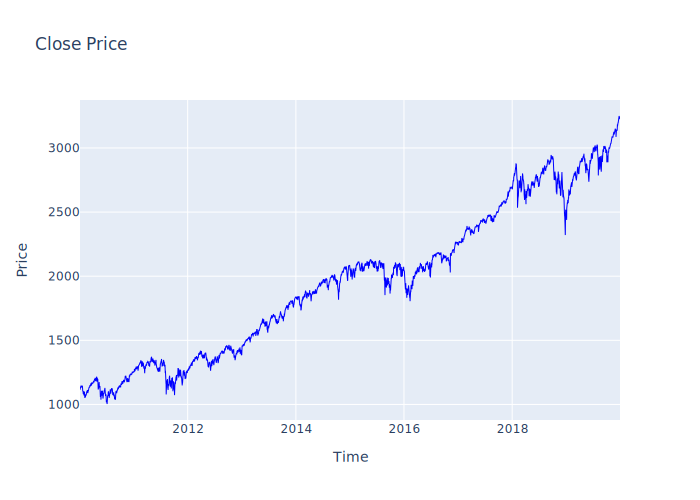

In [128]:
# $50,000 per bar
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 50000)
dollar_bars_df = pd.DataFrame(data=dollar_bars[:, 1:], index=dollar_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
dollar_bars_df = dollar_bars_df[~dollar_bars_df.index.duplicated(keep='first')]

fig = go.Figure(
    go.Scatter(x=dollar_bars_df.index, y=dollar_bars_df['close'],
               line=dict(color="blue", width=1), name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price")
fig.show()

Now let's apply the sequence of fractional differentiations given in the task. Here I use `d=0.7`.

In [129]:
d = 0.7
frac_diff_ffd(
    frac_diff_ffd(pd.DataFrame(dollar_bars_df['close']).reset_index(drop=True), d, thres=0.01),
    -d, thres=0.01
)

,close


We get the empty series whe using relatively large thresholds and the algorithm is not finishing for smaller thresholds.

### 5. Dollar Bar Series, part 2

Now we form a series of cumulative log-prices and apply FFD to it:

Minimum d required: 2.0


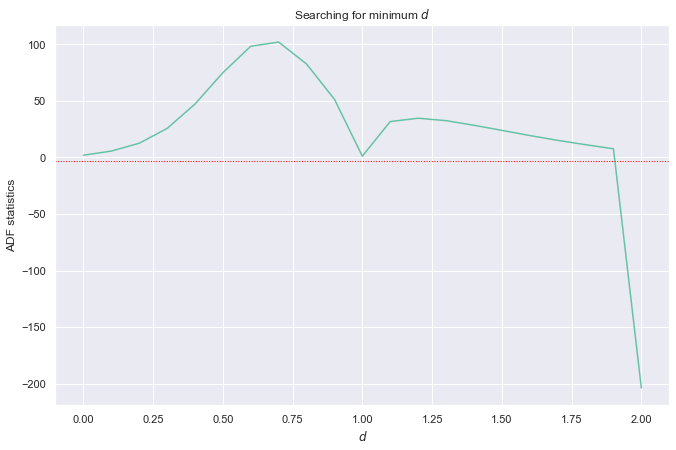

In [130]:
cumulative_log_close = np.cumsum(np.log(dollar_bars_df['close'].astype(float)))

plot_min_ffd(process=cumulative_log_close.values, apply_constant_width=True, thres=1e-5)

So `d=2` gives us the stationary series.

In [131]:
new_close = frac_diff_ffd(pd.DataFrame(cumulative_log_close.values), d=2, thres=1e-5)
corr = pearsonr(new_close[0].values, dollar_bars_df.close.values[2:])[0]
cointegration = coint(new_close[0].values, dollar_bars_df.close.values[2:])[:2]
jb = jarque_bera(new_close[0].values)[0]

print(f'Correlation with the initial close price series: {corr}')
print('Cointegration with the initial close price series:')
print(f'\tEngel-Granger statistics, p-value: {cointegration}')
print(f'FracDiff series JB statistic: {jb}')

Correlation with the initial close price series: 0.011502494081486311
Cointegration with the initial close price series:
	Engel-Granger statistics, p-value: (-36.292690685990834, 0.0)
FracDiff series JB statistic: 39390965.3052799


### 6. Dollar Bar Series, part 3

Here we apply CUSUM filter to the FracDiff series obtained in the previous task.

In [132]:
new_index = dollar_bars_df['close'].index[new_close.index]
new_close = pd.Series(new_close[0].values, index=new_index)

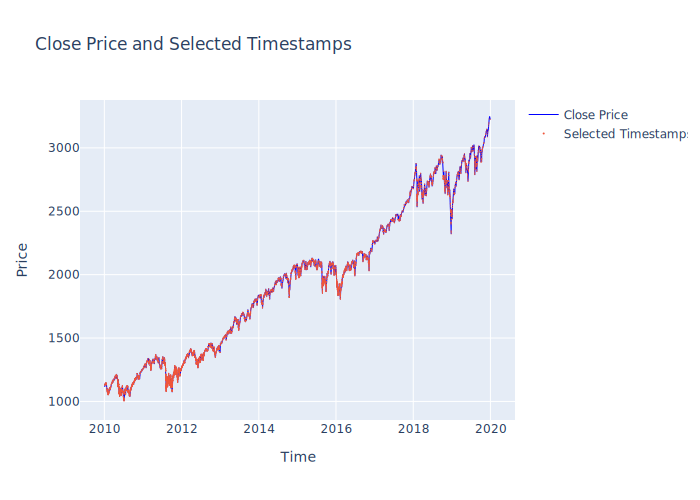

In [133]:
tEvents = getTEvents(new_close, h=2*np.std(new_close))
chosen_bars_df = dollar_bars_df.loc[tEvents, :]

fig = go.Figure(
    go.Scatter(x=dollar_bars_df.index, y=dollar_bars_df['close'],
               line=dict(color="blue", width=1), name='Close Price')
).update_layout(xaxis_title="Time", yaxis_title="Price", title="Close Price and Selected Timestamps")
fig.add_trace(go.Scatter(
    x=chosen_bars_df.index, y=chosen_bars_df['close'], mode='markers', marker=dict(size=1), name='Selected Timestamps'
    )
)
fig.show()

Now we form feature matrix using the events selected by the CUSUM filter:

In [134]:
feature_matrix = pd.DataFrame({'close': chosen_bars_df['close'], 'fracdiff_value': new_close[tEvents]})

From labels using the tripple-barrier method (symmetric horizontal barriers of twice the daily standard deviation, vertical barrier of 5 days):

In [135]:
t1 = add_vertical_barrier(chosen_bars_df['close'], tEvents, numDays=5)
t1

2010-01-04 15:31:02.000   2010-01-10 17:02:07.000
2010-01-04 16:26:25.000   2010-01-10 17:02:07.000
2010-01-05 15:34:19.000   2010-01-10 17:02:07.000
2010-01-05 17:49:08.000   2010-01-11 15:34:51.000
2010-01-06 21:36:06.000   2010-01-13 18:19:19.000
                                    ...          
2019-12-12 21:09:53.757   2019-12-20 08:11:47.600
2019-12-13 06:58:48.329   2019-12-20 08:11:47.600
2019-12-17 07:25:09.155   2019-12-30 08:08:53.765
2019-12-17 07:48:29.219   2019-12-30 08:08:53.765
2019-12-20 08:11:47.600   2019-12-30 08:08:53.765
Length: 8026, dtype: datetime64[ns]

In [136]:
events = get_events_tripple_barrier(close=chosen_bars_df['close'], tEvents=tEvents, pt_sl=[1, 1],
                                    trgt=2*get_daily_vol(chosen_bars_df['close']), minRet=0.01,
                                    numThreads=1, t1=t1)
events

,t1,trgt
2010-01-17 17:13:57.000,2010-01-19 15:44:06.000,0.011601
2010-01-18 02:53:53.000,2010-01-21 15:40:58.000,0.012342
2010-01-19 07:22:29.000,2010-01-19 15:31:57.000,0.011691
2010-01-19 15:31:57.000,2010-01-21 15:40:58.000,0.013083
2010-01-19 15:44:06.000,2010-01-21 15:40:58.000,0.014097
...,...,...
2019-12-13 06:58:48.329,2019-12-20 08:11:47.600,0.017297
2019-12-17 07:25:09.155,2019-12-30 08:08:53.765,0.016699
2019-12-17 07:48:29.219,2019-12-30 08:08:53.765,0.015984
2019-12-20 08:11:47.600,2019-12-30 08:08:53.765,0.015629


In [137]:
labels = get_bins(close=chosen_bars_df['close'], events=events, t1=t1)
labels

,ret,bin
2010-01-17 17:13:57.000,0.0123806,0
2010-01-18 02:53:53.000,-0.0205685,-1
2010-01-19 07:22:29.000,0.0121217,0
2010-01-19 15:31:57.000,-0.0300726,-1
2010-01-19 15:44:06.000,-0.0308351,-1
...,...,...
2019-12-12 21:09:53.757,0.0137567,0
2019-12-13 06:58:48.329,0.0178487,0
2019-12-17 07:25:09.155,0.00819211,0
2019-12-17 07:48:29.219,0.00951785,0


In [138]:
labels.describe()

,ret,bin
count,7602.0,7602
unique,7370.0,3
top,0.0,0
freq,11.0,5622


Now we can fit **bagging classifiers of decision trees**. The observed features are bootstrapped using the sequential method, and on each bootstrapped sample, sample weights are determined using the techniques from Chapter 4.

In [140]:
indM = get_ind_matrix(barIdx=chosen_bars_df['close'].index, t1=events['t1'])
avg_uniq = get_avg_uniqueness(indM)
avg_uniq

0       0.466667
1       0.209990
2       0.291667
3       0.168654
4       0.159616
          ...   
7598    0.258333
7599    0.258333
7600    0.261111
7601    0.266667
7602         NaN
Length: 7603, dtype: float64

In [141]:
num_co_events = num_conc_events(closeIdx=chosen_bars_df['close'].index, t1=events['t1'], molecule=events.index)
weights = sample_weights(t1=events['t1'], num_conc_events=num_co_events, molecule=events.index)
return_weights = sample_return_weights(t1=events['t1'], num_conc_events=num_co_events,
                                       close=chosen_bars_df['close'].astype(float), molecule=events.index)

data = feature_matrix.join(pd.DataFrame(weights, columns=['weight']), how='left') \
                     .join(pd.DataFrame(return_weights, columns=['return_weight']), how='left') \
                     .join(labels, how='left').dropna()
data.head()

,close,fracdiff_value,weight,return_weight,ret,bin
2010-01-17 17:13:57,1130.8,-0.00106063,0.466667,0.00226581,0.0123806,0
2010-01-18 02:53:53,1132.8,-0.00176398,0.209990,0.000304283,-0.0205685,-1
2010-01-19 07:22:29,1130.2,0.00212578,0.291667,0.00224627,0.0121217,0
2010-01-19 15:31:57,1143.9,0.0110761,0.168654,0.000421887,-0.0300726,-1
2010-01-19 15:44:06,1144.8,0.000786473,0.159616,0.0034341,-0.0308351,-1


In [145]:
X, y = data.drop('bin', axis=1), data['bin'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tree = DecisionTreeClassifier(class_weight='balanced')
bagging_clf = BaggingClassifier(base_estimator=tree, n_estimators=100, max_samples=avg_uniq.mean() , n_jobs=-1)
clf = OneVsRestClassifier(bagging_clf, n_jobs=-1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [146]:
def print_results(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Classification report:\n {classification_report(y_test, y_pred)}')

print_results(y_test, y_pred)

Accuracy: 0.7832719621251972
Classification report:
               precision    recall  f1-score   support

          -1       0.67      0.61      0.63       269
           0       0.81      0.93      0.86      1388
           1       0.68      0.16      0.25       244

    accuracy                           0.78      1901
   macro avg       0.72      0.56      0.58      1901
weighted avg       0.77      0.78      0.75      1901

